In [4]:
import numpy as np
from skimage import exposure
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from cellpose import models
import napari
import os
import cv2
import matplotlib.pyplot as plt

# Load your image
os.chdir("D:/data_for_seg/z_projection/split")
files = os.listdir()

# Load the first image in the directory in grayscale
image = cv2.imread(files[1], cv2.IMREAD_GRAYSCALE)

spacing = np.array([0.26, 0.26])

viewer = napari.view_image(
    image,
    scale=spacing,
    ndisplay=2,
)

# Get the selected image layer
selected_layer = viewer.layers.selection.active

# Convert the image to float
image = selected_layer.data.astype(float)

# Enhance the intensity of the cells using histogram equalization
equalized_image = exposure.equalize_hist(image)

# Add the enhanced image to the viewer
viewer.add_image(equalized_image, name='Enhanced Image')

# Segment the cells in the enhanced image using the Cellpose method
model = models.Cellpose(gpu=False, model_type='cyto')

# Run the model on the equalized image
masks, flows, styles, diams = model.eval(equalized_image, diameter=100, channels=[0,0])

# Add the segmented image to the viewer
viewer.add_labels(masks, name='Segmented Cells')

<Labels layer 'Segmented Cells' at 0x22f86701b10>

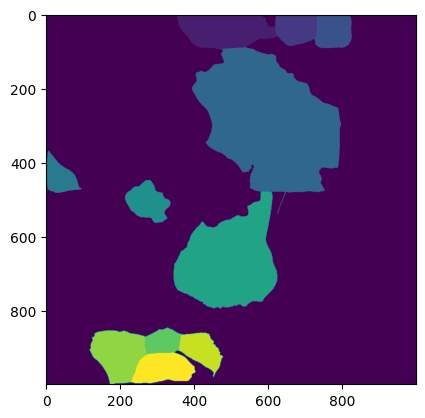

In [5]:
plt.imshow(masks)
plt.show()

In [3]:
import cv2
import os
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed

# Load your image
os.chdir("D:/data_for_seg/z_projection/split")
files = os.listdir()
img = cv2.imread(files[1], cv2.IMREAD_GRAYSCALE)

# Step 1: Image Enhancement
img_enhanced = cv2.equalizeHist(img)

# Step 2: Noise Reduction
img_smooth = cv2.medianBlur(img_enhanced, 3)

# Step 3: Thresholding using Otsu's method
_, img_thresh = cv2.threshold(img_smooth, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 4: Morphological Operations
kernel = np.ones((3,3),np.uint8)
img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)
img_morph = cv2.dilate(img_morph, kernel, iterations = 1)

# Step 5: Watershed Segmentation
dist_transform = distance_transform_edt(img_morph)
_, dist_output = cv2.threshold(dist_transform, 0.02 * dist_transform.max(), 255, 0)
dist_output = np.uint8(dist_output)
_, markers = cv2.connectedComponents(dist_output)
markers += 1
markers[img_morph == 0] = 0
watershed_img = watershed(-dist_transform, markers, mask=img_morph)
watershed_display = ((watershed_img - watershed_img.min()) * (255.0 / (watershed_img.max() - watershed_img.min()))).astype(np.uint8)

# Visualization
cv2.imshow("Original", img)
cv2.imshow("Enhanced", img_enhanced)
cv2.imshow("Thresholded", img_thresh)
cv2.imshow("Morphological Processing", img_morph)
cv2.imshow("Watershed", watershed_display)
cv2.waitKey(0)
cv2.destroyAllWindows()
